# 1 + 1 = 1 ou Pareamento de Registros com Python
Flávio Juvenal  
[@flaviojuvenal](https://twitter.com/flaviojuvenal)  

<p>
    Sócio e Desenvolvedor na <a href="http://www.vinta.com.br?dedupe-slides=1"><img class="vinta_logo" style="display: inline-block; margin-left: 0;" src="vinta.png" width=300></a>
</p>

Outras palestras da Vinta em: http://bit.ly/pybr-talks

In [1]:
import warnings; warnings.simplefilter('ignore')
import logging; logging.disable(level=logging.INFO)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Use isto para setar GOOGLE_API_KEY e ativar o geocoder
# Pegue uma em: https://cloud.google.com/maps-platform/#get-started
# Depois crie um arquivo .env com GOOGLE_API_KEY=valor-da-key
# E por fim rode as linhas comentadas abaixo:

from dotenv import load_dotenv
load_dotenv(verbose=True)

True

<p style="font-size: 2em; text-weight: bold">
    Slides disponíveis em: <a href="http://bit.ly/pybr-duplica">http://bit.ly/pybr-duplica</a>
</p>

## Registros reais são uma bagunça!
Provavelmente você já lidou com registros assim antes:

In [4]:
import pandas as pd

data = [
    ("Reteteu","R. Prof. Otávio de Freitas","Recife - PE"),
    ("Reteteu - Comida Honesta","R. Prof. Otavio de Freitas, 256","Recife (PE)"),
    ("Reteteu (Restaurante)","Rua Otávio de Freitas","Encruzilhada (Recife)"),
    ("Tio Pepe (Restaurante)", "R. Alm. Tamandaré, 170", "Boa Viagem (Recife)"),
    ("Tio Pepe", "Rua Almirate Tamamdare", "Recife"),
]

df = pd.DataFrame(data, columns=['restaurant', 'address', 'city'])

In [5]:
df

,restaurant,address,city
0,Reteteu,R. Prof. Otávio de Freitas,Recife - PE
1,Reteteu - Comida Honesta,"R. Prof. Otavio de Freitas, 256",Recife (PE)
2,Reteteu (Restaurante),Rua Otávio de Freitas,Encruzilhada (Recife)
3,Tio Pepe (Restaurante),"R. Alm. Tamandaré, 170",Boa Viagem (Recife)
4,Tio Pepe,Rua Almirate Tamamdare,Recife


A solução se chama **Pareamento de Registros** ([Record Linkage](https://en.wikipedia.org/wiki/Record_linkage)). Quando aplicado em um único dataset, se chama **Deduplicação de Registros** (Record Deduplication).

Consiste em comparar e unir registros de maneira **fuzzy**, utilizando campos imprecisos como nomes, endereços, telefones, datas, etc.

Não confundir com Deduplicação de _Dados_, que é associado a compressão e armazenamento.

## Comparando strings de forma fuzzy

In [6]:
import jellyfish

In [7]:
jellyfish.jaro_winkler("R. Prof. Otávio de Freitas", "Rua Otávio de Freitas")

0.7959224985540775

In [8]:
jellyfish.jaro_winkler("R. Prof. Otávio de Freitas", "R. Alm. Tamandaré, 170")

0.473970473970474

## Comparando endereços de forma fuzzy

Geocodificar endereços, i.e., convertê-los para **latitude/longitude** é bastante útil, pois possibilita:
- limpar variações irrelevantes (prof. vs. professor)
- calcular distância geométrica (mesma rua: mais perto, mais similar)

In [9]:
import requests
import geocoder

full_addresses = [
    "R. Alm. Tamandaré, 170, Boa Viagem (Recife)",
    "Rua Almirate Tamamdare, Recife",
]

full_addresses_latlng = []
with requests.Session() as session:
    for a in full_addresses:
        a_geocoded = geocoder.google(a, session=session)
        full_addresses_latlng.append((a_geocoded.latlng, a_geocoded.postal))

address_latlng = list(zip(full_addresses, full_addresses_latlng))

In [10]:
import pprint

pprint.pprint(address_latlng)

[('R. Alm. Tamandaré, 170, Boa Viagem (Recife)',
  ([-8.1340452, -34.9083392], '51030-090')),
 ('Rua Almirate Tamamdare, Recife', ([-8.1338926, -34.9082632], '51030'))]


## 5 passos para deduplicação
0. Pré-processamento
    * input: registros
    * output: registros limpos
1. Indexação
    * output: pares de registros
2. Comparação
    * output: para cada par, valores de similaridades (vetores)
3. Classificação
    * output: pares separados em duplicatas e não-duplicatas
4. Clusterização
    * output: clusters de registros

## 0/4 - Pré-processamento

Dataset fabricado baseado no dataset [Restaurant](https://www.cs.utexas.edu/users/ml/riddle/data.html):
- dataset frequentemente usado por pesquisadores
- consiste em 881 registros de restaurantes dos guias Fodor's e Zagat
- contem 150 registros duplicados

\* Verifique as mudanças que introduzimos fazendo um `diff restaurant.original.csv restaurant.csv`

Vamos carregar nosso dataset em um **dataframe** Pandas:

In [11]:
df_with_truth = pd.read_csv('restaurant.csv', skip_blank_lines=True)
df_with_truth.head(9)

,name,addr,city,phone,type,cluster
0,arnie morton's of chicago,435 s. la cienega blv.,los angeles,310/246-1501,american,0
1,arnie morton's of chicago,435 s. la cienega blvd.,los angeles,310-246-1501,steakhouses,0
2,arnie morton,435 s. la cienega boulevard,los angeles,310-246-1501,steakhouses,0
3,art's delicatessen,12224 ventura blvd.,studio city,818/762-1221,american,1
4,art's deli,12224 ventura blvd.,studio city,818-762-1221,delis,1
5,art's deli,12224 ventura blvd.,los angeles,818-762-1221,delis,1
6,hotel bel-air,701 stone canyon rd.,bel air,310/472-1211,californian,2
7,bel-air hotel,701 stone canyon rd.,bel air,310-472-1211,californian,2
8,bel-air,701 stone canyon road,bel air,(310) 472-1211,american,2


Este dataset vem com os registros deduplicados indicados pelo atributo `cluster`.

Para mostrar como fazer a deduplicação em um contexto difícil, vamos remover os atributos `phone` e `type`:

In [12]:
df = df_with_truth.drop(columns=['cluster', 'phone', 'type'])
df.head(9)

,name,addr,city
0,arnie morton's of chicago,435 s. la cienega blv.,los angeles
1,arnie morton's of chicago,435 s. la cienega blvd.,los angeles
2,arnie morton,435 s. la cienega boulevard,los angeles
3,art's delicatessen,12224 ventura blvd.,studio city
4,art's deli,12224 ventura blvd.,studio city
5,art's deli,12224 ventura blvd.,los angeles
6,hotel bel-air,701 stone canyon rd.,bel air
7,bel-air hotel,701 stone canyon rd.,bel air
8,bel-air,701 stone canyon road,bel air


Agora vamos pré-processar os registros. Primeiro, limpando `name`:

In [13]:
import re

irrelevant_regex = re.compile(r'[^a-z0-9\s]')
multispace_regex = re.compile(r'\s\s+')

def assign_no_symbols_name(df):
    return df.assign(
        name=df['name'].str.replace(irrelevant_regex, ' ').str.replace(multispace_regex, ' '))

df = assign_no_symbols_name(df)
df.head(9)

,name,addr,city
0,arnie morton s of chicago,435 s. la cienega blv.,los angeles
1,arnie morton s of chicago,435 s. la cienega blvd.,los angeles
2,arnie morton,435 s. la cienega boulevard,los angeles
3,art s delicatessen,12224 ventura blvd.,studio city
4,art s deli,12224 ventura blvd.,studio city
5,art s deli,12224 ventura blvd.,los angeles
6,hotel bel air,701 stone canyon rd.,bel air
7,bel air hotel,701 stone canyon rd.,bel air
8,bel air,701 stone canyon road,bel air


E depois geocodificando `addr`:

In [14]:
import numpy as np

all_addresses = df['addr'].str.cat(df['city'], sep=', ').values
unique_addresses = np.unique(all_addresses)
print(len(all_addresses), len(unique_addresses))

881 819


In [15]:
import os.path
import json

geocoding_filename = 'address_to_geocoding.json'

def geocode_addresses(address_to_geocoding):
    remaining_addresses = (
        set(unique_addresses) -
        set(k for k, v in address_to_geocoding.items() if v is not None and 'lat' in v))

    with requests.Session() as session:
        for i, address in enumerate(remaining_addresses):
            print(f"Geocoding {i + 1}/{len(remaining_addresses)}")
            geocode_result = geocoder.google(address, session=session)
            address_to_geocoding[address] = geocode_result.json

        with open(geocoding_filename, 'w') as f:
            json.dump(address_to_geocoding, f, indent=4)

if not os.path.exists(geocoding_filename):
    address_to_geocoding = {}
    geocode_addresses(address_to_geocoding)
else:
    with open(geocoding_filename) as f:
        address_to_geocoding = json.load(f)
    geocode_addresses(address_to_geocoding)
 
address_to_postal = {
    k: v['postal']
    for k, v in address_to_geocoding.items()
    if v is not None and 'postal' in v
}
address_to_latlng = {
    k: (v['lat'], v['lng'])
    for k, v in address_to_geocoding.items()
    if v is not None
}
print(f"Failed to get postal from {len(address_to_geocoding) - len(address_to_postal)}")
print(f"Failed to get latlng from {len(address_to_geocoding) - len(address_to_latlng)}")

Geocoding 1/1
Failed to get postal from 11
Failed to get latlng from 1


In [16]:
def assign_postal_lat_lng(df):
    addresses = df['addr'].str.cat(df['city'], sep=', ')
    addresses_to_postal = [address_to_postal.get(a) for a in addresses]
    addresses_to_lat = [address_to_latlng[a][0] if a in address_to_latlng else None for a in addresses]
    addresses_to_lng = [address_to_latlng[a][1] if a in address_to_latlng else None for a in addresses]

    return df.assign(postal=addresses_to_postal, lat=addresses_to_lat, lng=addresses_to_lng)

df = assign_postal_lat_lng(df)
df.head(6)

,name,addr,city,postal,lat,lng
0,arnie morton s of chicago,435 s. la cienega blv.,los angeles,90048,34.070708,-118.376563
1,arnie morton s of chicago,435 s. la cienega blvd.,los angeles,90048,34.070708,-118.376563
2,arnie morton,435 s. la cienega boulevard,los angeles,90048,34.070708,-118.376563
3,art s delicatessen,12224 ventura blvd.,studio city,91604,34.142963,-118.399465
4,art s deli,12224 ventura blvd.,studio city,91604,34.142963,-118.399465
5,art s deli,12224 ventura blvd.,los angeles,91604,34.142963,-118.399465


Assim **limpamos** e **enriquecemos** nossos registros.

## 1/4 - Indexação

Nós temos os registros limpos, agora nós precisamos dos **pares** dos registros para compará-los e encontrar duplicatas.


Para os próximos passos, usaremos a biblioteca **recordlinkage**, aka **[Python Record Linkage Toolkit](http://recordlinkage.readthedocs.io/en/stable/)**.

recordlinkage suporta **dataframes Pandas**, então não precisaremos adaptar os dados que já temos.


Pra produzir os pares, podemos fazer uma indexação complexa usando a classe `Full`. Como isso, teremos que comparar todos os registros entre si:

In [17]:
import recordlinkage as rl
from recordlinkage.index import Full

full_indexer = Full()
pairs = full_indexer.index(df)

print(f"Full index: {len(df)} records, {len(pairs)} pairs")

Full index: 881 records, 387640 pairs


<div><img style="display: block; margin: 0 auto;" src="full-indexing.png?" width=1200></div>

O problema é que o número de pares cresce muito rápido, i.e., **quadraticamente** na medida que os registros crescem: `len(df) * (len(df) - 1) / 2`

Para evitar tantas comparações e perda de tempo, precisamos **indexar**. Precisamos produzir **apenas** os pares que têm uma chance mínima representar duplicatas.

A forma mais básica de indexar se chama **blocking**. É uma regra de indexação que produz pares **que possuem um valor em comum**.

<div><img style="display: block; margin: 0 auto;" src="standard-blocking.png?" width=1000></div>

No nosso exemplo, vamos produzir pares com o mesmo valor para **postal** (código postal) usando a classe `Block`:

In [18]:
from recordlinkage.index import Block

postal_indexer = Block('postal')
pairs = postal_indexer.index(df)

print(f"Postal index: {len(pairs)} pairs")

Postal index: 6462 pairs


In [19]:
# We'll swap the levels of pairs MultiIndex returned by recordlinkage
# to make it simpler to interpret. Here we get the upper triangle of the pairs matrix.
pairs = pairs.swaplevel().sortlevel()[0]

In [20]:
pairs.to_frame()[:10].values

array([[  0,   1],
       [  0,   2],
       [  0,  32],
       [  0,  33],
       [  0,  35],
       [  0,  36],
       [  0, 262],
       [  0, 266],
       [  0, 273],
       [  0, 293]])

In [21]:
df[['name', 'postal']].head(3)

,name,postal
0,arnie morton s of chicago,90048
1,arnie morton s of chicago,90048
2,arnie morton,90048


Existem muitas outras formas de indexação além de **Blocking**:
* Sorted Neighborhood
* Canopy Clustering
* Locality Sensitive Hashing
* ou até... **aprender** como indexar com Machine Learning

## 2/4 - Comparação

Com os pares, vamos produzir um **vetor** (feature vector) para cada par.  
Cada vetor contem as similaridades dos atributos. Algo como:

In [22]:
pd.DataFrame([[0.5, 0.8, 0.9, 1]],
             columns=['name', 'addr', 'postal', 'latlng'],
             index=pd.MultiIndex.from_arrays([[100], [200]]))

,,name,addr,postal,latlng
100,200,0.5,0.8,0.9,1


In [23]:
pd.DataFrame([[0.5, 0.8, 0.9, 1]],
             columns=['name', 'addr', 'postal', 'latlng'],
             index=pd.MultiIndex.from_arrays([[100], [200]]))

,,name,addr,postal,latlng
100,200,0.5,0.8,0.9,1


Nesse exemplo, o par `(100, 200)` possui:
- Valores pouco parecidos em `name`
- Valores parecidos em `addr`
- Valores muito parecidos em `postal`
- Valores iguais de `latlng`

Para computar esse vetor, preciamos definir pelo menos **uma função de similaridade** para cada atributo:

In [24]:
comp = rl.Compare()
comp.string('name', 'name', method='jarowinkler', label='name')
comp.string('addr', 'addr', method='jarowinkler', label='addr')
comp.string('postal', 'postal', method='jarowinkler', label='postal')
comp.geo('lat', 'lng', 'lat', 'lng', method='exp', scale=0.1, offset=0.01, label='latlng');

Depois, é só chamar o `compute` com os pares indexados `pairs` e os registros `df` para obter os **vetores**:

In [25]:
comparison_vectors = comp.compute(pairs, df)
comparison_vectors.head(5)

name      addr  postal    latlng
0 1   1.000000  0.985507     1.0  1.000000
  2   0.896000  0.910774     1.0  1.000000
  32  0.520128  0.580927     1.0  0.000025
  33  0.556630  0.580927     1.0  0.000025
  35  0.505476  0.528075     1.0  0.030131

## 3/4 - Classificação

Com nossos vetores, vamos explorar **diferentes formas** de classificá-los como duplicatas ou não.

### Classificação por limiar

Uma maneira simples de classificar os vetores como duplicatas ou não é computar uma **média ponderada** para servir de **pontuação** (score) e usar um **limiar** (threshold):

In [26]:
scores = np.average(
    comparison_vectors.values,
    axis=1,
    weights=[50, 30, 10, 20])
scored_comparison_vectors = comparison_vectors.assign(score=scores)
scored_comparison_vectors.head(5)

name      addr  postal    latlng     score
0 1   1.000000  0.985507     1.0  1.000000  0.996047
  2   0.896000  0.910774     1.0  1.000000  0.928393
  32  0.520128  0.580927     1.0  0.000025  0.485770
  33  0.556630  0.580927     1.0  0.000025  0.502362
  35  0.505476  0.528075     1.0  0.030131  0.470170

Sabemos que o registro `0` realmente é uma duplicata do `1` e `2`. Para simplificar, vamos **classificar como duplicatas** quaisquer pares com `score >= 0.9`. Este é o nosso **limiar**:

In [27]:
matches = scored_comparison_vectors[
    scored_comparison_vectors['score'] >= 0.9]
matches.head(6)

name      addr  postal  latlng     score
0 1  1.000000  0.985507     1.0     1.0  0.996047
  2  0.896000  0.910774     1.0     1.0  0.928393
1 2  0.896000  0.923779     1.0     1.0  0.931940
3 4  0.911111  1.000000     1.0     1.0  0.959596
  5  0.911111  1.000000     1.0     1.0  0.959596
4 5  1.000000  1.000000     1.0     1.0  1.000000

Já que temos os registros duplicados marcados pelo atributo `cluster`, podemos **avaliar** o quão bom é o nosso método de classificação por limiar:

In [28]:
golden_pairs = Block('cluster').index(df_with_truth)
golden_pairs = golden_pairs.swaplevel().sortlevel()[0]
print("Golden pairs:", len(golden_pairs))

Golden pairs: 150


In [29]:
found_pairs_set = set(matches.index)

golden_pairs_set = set(golden_pairs)

true_positives = golden_pairs_set & found_pairs_set
false_positives = found_pairs_set - golden_pairs_set
false_negatives = golden_pairs_set - found_pairs_set

print('true_positives total:', len(true_positives))
print('false_positives total:', len(false_positives))
print('false_negatives total:', len(false_negatives))

true_positives total: 128
false_positives total: 2
false_negatives total: 22


Tivemos um pequeno número de **falso positivos**. São casos complicados, pois são pares de registros praticamente idênticos mas que não representam o mesmo restaurante:

In [30]:
print(f"False positives:")
for false_positive_pair in false_positives:
    display(df.loc[list(false_positive_pair)][['name', 'addr', 'postal', 'lat', 'lng']])

False positives:


,name,addr,postal,lat,lng
196,ritz carlton cafe buckhead,3434 peachtree rd. ne,30326,33.850488,-84.363631
198,ritz carlton dining room buckhead,3434 peachtree rd. ne,30326,33.850488,-84.363631


,name,addr,postal,lat,lng
200,ritz carlton restaurant,181 peachtree st.,30303,33.758572,-84.387181
839,ritz carlton cafe atlanta,181 peachtree st.,30303,33.758572,-84.387181


Por outro lado, tivemos um alto número de **falso negativos**. Nosso método por limiar **perdeu** muitas duplicatas!

In [31]:
print(f"False negatives (sample 10 of {len(false_negatives)}):")
for false_negative_pair in list(false_negatives)[:10]:
    display(df.loc[list(false_negative_pair)][['name', 'addr', 'postal', 'lat', 'lng']])

False negatives (sample 10 of 22):


,name,addr,postal,lat,lng
182,heera of india,595 piedmont ave. rio shopping mall,30324,33.798336,-84.371044
183,heera of india,595 piedmont ave.,30308,33.770298,-84.381122


,name,addr,postal,lat,lng
164,abruzzi,2355 peachtree rd. peachtree battle shopping ...,30305,33.819818,-84.386643
165,abruzzi,2355 peachtree rd. ne,30305,33.819166,-84.387518


,name,addr,postal,lat,lng
28,restaurant katsu,1972 n. hillhurst ave.,90027,34.107403,-118.287172
29,katsu,1972 hillhurst ave.,90027,34.107403,-118.287172


,name,addr,postal,lat,lng
36,locanda veneta,8638 w 3rd,90048,34.073421,-118.381098
37,locanda,w. third st.,None,34.068947,-118.322599


,name,addr,postal,lat,lng
40,the palm,9001 santa monica blvd.,90069,34.083473,-118.387373
41,palm the los angeles,9001 santa monica blvd.,90069,34.083064,-118.387282


,name,addr,postal,lat,lng
136,shun lee west,43 w. 65th st.,10023,40.772900,-73.981348
137,shun lee palace,155 e. 55th st.,10022,40.759435,-73.969072


,name,addr,postal,lat,lng
34,locanda veneta,3rd st.,None,34.009031,-118.488174
35,locanda veneta,8638 w. third st.,90048,34.073421,-118.381098


,name,addr,postal,lat,lng
110,mesa grill,102 5th ave. between 15th and 16th sts.,10001,40.748441,-73.985664
111,mesa grill,102 fifth ave.,10011,40.737045,-73.993119


,name,addr,postal,lat,lng
35,locanda veneta,8638 w. third st.,90048,34.073421,-118.381098
37,locanda,w. third st.,None,34.068947,-118.322599


,name,addr,postal,lat,lng
144,uncle nick s,747 9th ave. between 50th and 51st sts.,10019,40.763835,-73.988912
145,uncle nick s,747 ninth ave.,10019,40.763884,-73.989002


Ao invés de tentar **advinhar** um limiar, podemos fazer algo mais inteligente?

### Classificação supervisionada

Podemos treinar um **classificador** capaz de classificar os pares em duplicatas ou não, baseado em um dataset de treinamento que podemos providenciar:

In [32]:
df_training = pd.read_csv('restaurant-training.csv', skip_blank_lines=True)
df_training = df_training.drop(columns=['type', 'phone'])
df_training

,name,addr,city,cluster
0,locanda veneta,3rd st.,los angeles,13
1,locanda veneta,8638 w. third st.,los angeles,13
2,locanda veneta,8638 w 3rd,st los angeles,13
3,cafe lalo,201 w. 83rd st.,new york,26
4,cafe lalo,201 w. 83rd st.,new york city,26
5,les celebrites,160 central park s,new york,42
6,les celebrites,155 w. 58th st.,new york city,42
7,second avenue deli,156 2nd ave. at 10th st.,new york,58
8,second avenue deli,156 second ave.,new york city,58
9,smith & wollensky,201 e. 49th st.,new york,62


Para o classificador aprender corretamente, devemos **pré-processar** nosso dataset de treinamento também:

In [33]:
df_training = assign_no_symbols_name(df_training)
df_training = assign_postal_lat_lng(df_training)
df_training.head(5)

,name,addr,city,cluster,postal,lat,lng
0,locanda veneta,3rd st.,los angeles,13,None,34.009031,-118.488174
1,locanda veneta,8638 w. third st.,los angeles,13,90048,34.073421,-118.381098
2,locanda veneta,8638 w 3rd,st los angeles,13,90048,34.073421,-118.381098
3,cafe lalo,201 w. 83rd st.,new york,26,10024,40.785981,-73.976727
4,cafe lalo,201 w. 83rd st.,new york city,26,10024,40.785981,-73.976727


O classificador que usaremos é o **Support Vector Machine**. SVMs são bons para deduplicação pois:
- São resilientes a ruídos nos dados (pares incorretos no treinamento, colunas faltando, etc.)
- Aceitam atributos (features) com similaridades correlacionadas (como 'addr' e 'latlng')
- São robustos a desbalanceamento de classes no dataset de treinamento  
(e.g. mais não-duplicatas, menos duplicatas, o que é natural em deduplicação) [3]

In [34]:
all_training_pairs = Full().index(df_training)
matches_training_pairs = Block('cluster').index(df_training)

training_vectors = comp.compute(all_training_pairs, df_training)

svm = rl.SVMClassifier()
svm.fit(training_vectors, matches_training_pairs);

In [35]:
svm_pairs = svm.predict(comparison_vectors)
svm_found_pairs_set = set(svm_pairs)

svm_true_positives = golden_pairs_set & svm_found_pairs_set
svm_false_positives = svm_found_pairs_set - golden_pairs_set
svm_false_negatives = golden_pairs_set - svm_found_pairs_set

print('true_positives total:', len(true_positives))
print('false_positives total:', len(false_positives))
print('false_negatives total:', len(false_negatives))
print()
print('svm_true_positives total:', len(svm_true_positives))
print('svm_false_positives total:', len(svm_false_positives))
print('svm_false_negatives total:', len(svm_false_negatives))

true_positives total: 128
false_positives total: 2
false_negatives total: 22

svm_true_positives total: 133
svm_false_positives total: 3
svm_false_negatives total: 17


Um **pouco melhor**, mas pouca diferença...

Poderíamos tentar [outros classificadores](https://recordlinkage.readthedocs.io/en/stable/notebooks/classifiers.html) disponíveis na biblioteca recordlinkage, mas a verdade é:
- É bem difícil **difícil montar um dataset de treinamento** com exemplos suficientes para os várias casos de similaridade de atributos;
- É bem difícil **escolher os atributos para blocking**. Talvez estamos:
  * introduzindo falso negativos (perdendo duplicatas reais) devido ao blocking (não possuem o mesmo `postal`)
  * introduzindo falso positivos (adicionando duplicatas falsas) devido ao blocking + classificador permissivos (possuem mesmo `postal` e são muito parecidas para o classificador)

Para lidar com essas **incertezas** temos...

### Classificação Active Learning

Métodos Active Learning identificam **pares para treinamento** que maximizam a qualidade dos resultados (precision/recall) [3].

É possível otimizar tanto as **atributos e regras de blocking** quanto o **classificador**.

Uma biblioteca Python chamada [**Dedupe**](https://docs.dedupe.io/en/latest/index.html) implementa Active Learning. Vamos vê-la na prática:

In [36]:
import logging; logging.disable(level=logging.NOTSET)

In [37]:
from svm_dedupe import SVMDedupe
import dedupe

fields = [
    {
        'field': 'name', 'variable name': 'name', 'type': 'JaroWinkler',
    },
    {
        'field': 'addr', 'variable name': 'addr', 'type': 'JaroWinkler',
    },
    {
        'field': 'postal', 'variable name': 'postal', 'type': 'JaroWinkler'
    },
    {
        'field': 'latlng', 'variable name': 'latlng', 'type': 'ExpLatLong'
    },
]

deduper = SVMDedupe(fields)

In [38]:
settings_filename = 'dedupe-simple-settings.pickle'
if os.path.exists(settings_filename):
    with open(settings_filename, 'rb') as sf:
        deduper = dedupe.StaticDedupe(sf, num_cores=4)

INFO:dedupe.api:((SimplePredicate: (firstIntegerPredicate, addr), SimplePredicate: (sameFiveCharStartPredicate, name)), (SimplePredicate: (latLongGridPredicate, latlng), SimplePredicate: (oneGramFingerprint, name)))


Precisamos **adaptar** os dados para o formato que o Dedupe trabalha, pois ele não trabalha com dataframes:

In [39]:
data_for_dedupe = df.assign(cluster=df_with_truth['cluster']).to_dict('index')
for record in data_for_dedupe.values():
    # Change nans to None
    for k, v in record.items():
        if isinstance(v, float) and np.isnan(v):
            record[k] = None
    
    # Move lat and lng to a single field latlng
    lat = record.pop('lat')
    lng = record.pop('lng')
    if lat is not None and lng is not None:
        record['latlng'] = (lat, lng)
    else:
        record['latlng'] = None

O processo de Active Learning consiste em iterativamente **marcar** como duplicata ou não-duplicata cada par que o Dedupe quer aprender. São esses os pares que mais o ajudarão a escolher as regras de blocking e treinar o classificador.

In [40]:
#     deduper.sample(data_for_dedupe)  
#     dedupe.consoleLabel(deduper)
#     deduper.train(index_predicates=False)

with open('training-simple-input-output.txt') as t:
    print('\n'.join(t.read().split('\n')[:262]))
    print('...')

name : philippe the original
addr : 1001 north alameda
postal : 90012
latlng : (34.059721, -118.237025)

name : pisces
addr : 95 ave. a
postal : 10009
latlng : (40.7256332, -73.984031)

0/10 positive, 0/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished
n

name : philippe the original
addr : 1001 n. alameda st.
postal : 90012
latlng : (34.059721, -118.237025)

name : mon kee seafood restaurant
addr : 679 n. spring st.
postal : 90012
latlng : (34.0595568, -118.2382488)

0/10 positive, 1/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished
n

name : caffe vivaldi
addr : 32 jones st. at bleecker st.
postal : 10014
latlng : (40.7317316, -74.00298049999999)

name : patria
addr : 250 park ave. s at 20th st.
postal : 10003
latlng : (40.7382552, -73.988214)

0/10 positive, 2/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished
n

name : i trulli
addr : 122 e. 27th st.  between le

Você pode checar o treinamento completo em `training-simple-input-output.txt`.

Se você quiser treinar novamente, faça um `rm dedupe-simple-settings.pickle dedupe-simple-training.json`, descomente as linhas acima, e rode tudo de novo desde a inicialização do `deduper`.

In [41]:
from dedupe.convenience import unique

def auto_label(deduper):
    # based on: dedupe.convenience.consoleLabel
    fields = unique(field.field
                    for field
                    in deduper.data_model.primary_fields)
    n_match = 0
    n_distinct = 0
    buffer_len = 1
    examples_buffer = []
    uncertain_pairs = []
    
    while n_match < 12 or n_distinct < 20:
        if not uncertain_pairs:
            uncertain_pairs = deduper.uncertainPairs()
        record_pair = uncertain_pairs.pop()
        
        n_match = (len(deduper.training_pairs['match']) +
                   sum(label == 'match' for _, label in examples_buffer))
        n_distinct = (len(deduper.training_pairs['distinct']) +
                      sum(label == 'distinct' for _, label in examples_buffer))
        
        for pair in record_pair:
            for field in fields:
                line = "%s : %s" % (field, pair[field])
                print(line)
            print()
        print(f"{n_match}/10 positive, {n_distinct}/10 negative")
        print("Do these records refer to the same thing?")
        print("(y)es / (n)o / (u)nsure / (f)inished")
        
        if record_pair[0]['cluster'] == record_pair[1]['cluster']:
            print('y')
            examples_buffer.insert(0, (record_pair, 'match'))
        else:
            print('n')
            examples_buffer.insert(0, (record_pair, 'distinct'))
        print()

        if len(examples_buffer) > buffer_len:
            record_pair, label = examples_buffer.pop()
            if label in ['distinct', 'match']:
                examples = {'distinct': [], 'match': []}
                examples[label].append(record_pair)
                deduper.markPairs(examples)
    
    for record_pair, label in examples_buffer:
        if label in ['distinct', 'match']:
            examples = {'distinct': [], 'match': []}
            examples[label].append(record_pair)
            deduper.markPairs(examples)

In [42]:
if not isinstance(deduper, dedupe.StaticDedupe):
    deduper.sample(data_for_dedupe)
    
    training_filename = 'dedupe-simple-training.json'
    if os.path.exists(training_filename):
        with open(training_filename) as tf:
            deduper.readTraining(tf)

#     dedupe.consoleLabel(deduper)  # se quiser treinar você mesmo, descomente essa linha e comente a linha abaixo
    auto_label(deduper)
    
    with open(training_filename, 'w') as tf:
        deduper.writeTraining(tf)
    
    deduper.train(index_predicates=False)
    
    with open(settings_filename, 'wb') as sf:
        deduper.writeSettings(sf)

Depois do processo de Active Learning, podemos ver quais **regras de blocking** o `deduper` aprendeu. É bom checar para ver se faz sentido:

In [43]:
deduper.predicates

((SimplePredicate: (firstIntegerPredicate, addr),
  SimplePredicate: (sameFiveCharStartPredicate, name)),
 (SimplePredicate: (latLongGridPredicate, latlng),
  SimplePredicate: (oneGramFingerprint, name)))

Essas foram as regras que o `deduper` aprendeu desta longa lista de **possíveis regras**:

In [44]:
deduper.data_model.predicates()

{SimplePredicate: (alphaNumericPredicate, addr),
 SimplePredicate: (alphaNumericPredicate, name),
 SimplePredicate: (alphaNumericPredicate, postal),
 SimplePredicate: (commonFourGram, addr),
 SimplePredicate: (commonFourGram, name),
 SimplePredicate: (commonFourGram, postal),
 SimplePredicate: (commonIntegerPredicate, addr),
 SimplePredicate: (commonIntegerPredicate, name),
 SimplePredicate: (commonIntegerPredicate, postal),
 SimplePredicate: (commonSixGram, addr),
 SimplePredicate: (commonSixGram, name),
 SimplePredicate: (commonSixGram, postal),
 SimplePredicate: (commonThreeTokens, addr),
 SimplePredicate: (commonThreeTokens, name),
 SimplePredicate: (commonThreeTokens, postal),
 SimplePredicate: (commonTwoTokens, addr),
 SimplePredicate: (commonTwoTokens, name),
 SimplePredicate: (commonTwoTokens, postal),
 SimplePredicate: (doubleMetaphone, addr),
 SimplePredicate: (doubleMetaphone, name),
 SimplePredicate: (doubleMetaphone, postal),
 SimplePredicate: (fingerprint, addr),
 SimpleP

Para terminar o processo de deduplicação com o `deduper`, computamos o **clustering threshold** (limiar) e chamamos **match**:

In [45]:
import itertools

threshold = deduper.threshold(data_for_dedupe, recall_weight=2)
clustered_dupes = deduper.match(data_for_dedupe, threshold=threshold)

INFO:dedupe.api:Maximum expected recall and precision
INFO:dedupe.api:recall: 0.999
INFO:dedupe.api:precision: 0.707
INFO:dedupe.api:With threshold: 0.209


Vamos avaliar como o Dedupe performou. Um pequeno **ajuste** é necessário, pois o Dedupe já retorna os clusters ao invés dos pares:

In [46]:
dedupe_found_pairs_set = set()
for cluster, __ in clustered_dupes:  # we'll explain that later
    for pair in itertools.combinations(cluster, 2):
        dedupe_found_pairs_set.add(tuple(pair))

In [47]:
dedupe_true_positives = golden_pairs_set & dedupe_found_pairs_set
dedupe_false_positives = dedupe_found_pairs_set - golden_pairs_set
dedupe_false_negatives = golden_pairs_set - dedupe_found_pairs_set

print('true_positives total:', len(true_positives))
print('false_positives total:', len(false_positives))
print('false_negatives total:', len(false_negatives))
print()
print('svm_true_positives total:', len(svm_true_positives))
print('svm_false_positives total:', len(svm_false_positives))
print('svm_false_negatives total:', len(svm_false_negatives))
print()
print('dedupe_true_positives total:', len(dedupe_true_positives))
print('dedupe_false_positives total:', len(dedupe_false_positives))
print('dedupe_false_negatives total:', len(dedupe_false_negatives))

true_positives total: 128
false_positives total: 2
false_negatives total: 22

svm_true_positives total: 133
svm_false_positives total: 3
svm_false_negatives total: 17

dedupe_true_positives total: 140
dedupe_false_positives total: 2
dedupe_false_negatives total: 10


## 4/4 - Clusterização

O recordlinkage retorna os **pares de duplicatas**. Mas o Dedupe vai além e retorna os **clusters de duplicatas**:

In [48]:
clustered_dupes[:5]

[((0, 1, 2), array([0.71667973, 0.71725396, 0.68507793])),
 ((3, 4, 5), array([0.70119166, 0.726287  , 0.726287  ])),
 ((6, 7, 8), array([0.19940663, 0.56712872, 0.26079245])),
 ((9, 10, 11, 12), array([0.75352792, 0.75352792, 0.75352792, 0.75272876])),
 ((13, 14), (0.7539285, 0.7539285))]

Dedupe finalizou o processo pois **combinou os pares de duplicatas em clusters**. Isso é essencial, pois o seguinte problema pode ocorrer:
- Temos os registros `A`, `B`, e `C`
- Após deduplicar, temos os pares:
- `(A, B)` duplicata
- `(B, C)` duplicata
- `(A, C)` não-duplicata
- E isso **não faz sentido**!

A solução a essa ambiguidade se chama computar a **Transitive Closure** através de **clustering**.

Usando alguns métodos privados do Dedupe, é possível computar os **pares de duplicatas** (sem clustering):

In [49]:
from dedupe.core import scoreDuplicates

candidate_records = itertools.chain.from_iterable(deduper._blockedPairs(deduper._blockData(data_for_dedupe)))
dedupe_matches = scoreDuplicates(candidate_records,
                                 deduper.data_model,
                                 deduper.classifier,
                                 deduper.num_cores)
dedupe_unclustered_pairs_score_dict = {tuple(pair): score for (pair, score) in dedupe_matches}
dedupe_unclustered_found_pairs_set = set(dedupe_unclustered_pairs_score_dict.keys())

Vamos avaliar os pares **unclustered** contra os **clustered**:

In [50]:
dedupe_unclustered_true_positives = golden_pairs_set & dedupe_unclustered_found_pairs_set
dedupe_unclustered_false_positives = dedupe_unclustered_found_pairs_set - golden_pairs_set
dedupe_unclustered_false_negatives = golden_pairs_set - dedupe_unclustered_found_pairs_set

print('dedupe_true_positives total:', len(dedupe_true_positives))
print('dedupe_false_positives total:', len(dedupe_false_positives))
print('dedupe_false_negatives total:', len(dedupe_false_negatives))
print()
print('dedupe_unclustered_true_positives total:', len(dedupe_unclustered_true_positives))
print('dedupe_unclustered_false_positives total:', len(dedupe_unclustered_false_positives))
print('dedupe_unclustered_false_negatives total:', len(dedupe_unclustered_false_negatives))

dedupe_true_positives total: 140
dedupe_false_positives total: 2
dedupe_false_negatives total: 10

dedupe_unclustered_true_positives total: 138
dedupe_unclustered_false_positives total: 5
dedupe_unclustered_false_negatives total: 12


Pares Unclustered `!=` Pares Clustered

O processo de clustering pode **criar duplicatas** e **remover duplicatas** para resolver ambiguidades.

In [51]:
diff_set = dedupe_found_pairs_set ^ dedupe_unclustered_found_pairs_set
display(diff_set)

{(6, 8), (40, 41), (120, 471), (121, 471), (196, 198), (199, 839), (487, 775)}

Aqui está um exemplo onde o clustering cria um novo par e **resolve uma ambiguidade**:

,name,addr,city,postal,lat,lng
40,the palm,9001 santa monica blvd.,los angeles,90069,34.083473,-118.387373
41,palm the los angeles,9001 santa monica blvd.,w. hollywood,90069,34.083064,-118.387282
42,the palm los angeles,9001 sta monica boulevard,hollywood,90069,34.083064,-118.387282


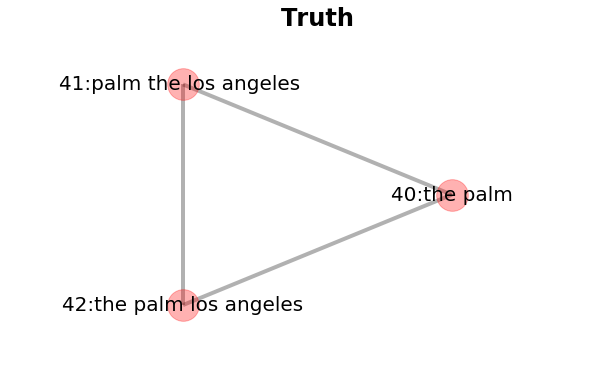

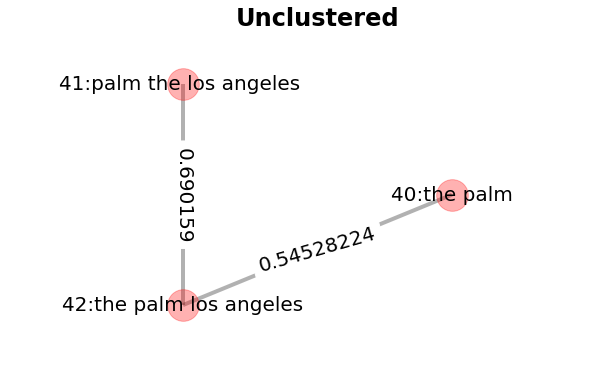

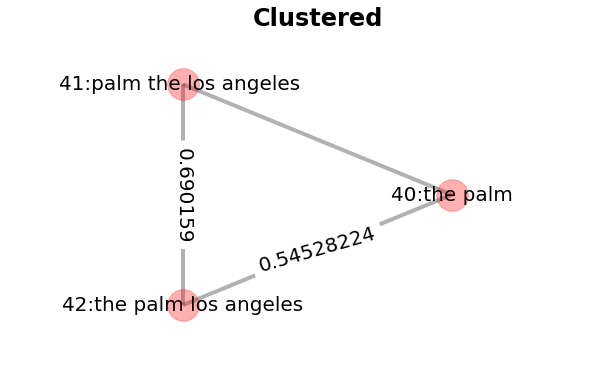

In [53]:
from graph_utils import show_cluster_graphs

diff_ids = {40, 41, 42}
show_cluster_graphs(
    df,
    golden_pairs_set, dedupe_found_pairs_set, dedupe_unclustered_found_pairs_set,
    dedupe_unclustered_pairs_score_dict,
    diff_ids)

## Próximos Passos

Procure aprender sobre outros métodos de pré-processamentro, indexação, funções de similaridade, classificadores, etc. Também verifique outros processos como "Probabilitic Record Linkage".

É interessante começar pela palestra **The Art and Science of Data Matching** [1] e pelo livro **Data Matching** [2].

Tendo os clusters, como consolidar os dados de vários registros duplicados em um só? Ver **Data Fusion**:
  - [Open issue at Python Record Linkage Toolkit](https://github.com/J535D165/recordlinkage/issues/27)
  - Christen, 6.12 Merging Matches [2]

E se novos registros forem adicionados ao dataset? Como lidar com os clusters já formados? Ver **Incremental Record Linkage**:
  - A abordagem recomendada pela biblioteca Dedupe é adicionar a um cluster existente ou criar um novo cluster. Para isso, usar a classe [Gazetteer](https://docs.dedupe.io/en/latest/API-documentation.html#gazetteer-objects).
  - Outras abordagens, ver os papers:
      * [Online Correlation Clustering](https://arxiv.org/pdf/1001.0920.pdf)
      * [Incremental Record Linkage](http://www.vldb.org/pvldb/vol7/p697-gruenheid.pdf)
      * [Heuristic-based approaches for speeding up incremental record linkage](https://www.sciencedirect.com/science/article/pii/S0164121217302972)

## Referências

- **Referenciados** nos slides:
    * [1] [Mike Mull, The Art and Science of Data Matching](https://www.youtube.com/watch?v=Y-nYEOgq3YE) (slides [here](https://github.com/mikemull/Notebooks/blob/master/PyDataNYCSlides.ipynb))
    * [2] [Peter Christen, Data Matching](http://www.springer.com/us/book/9783642311635)
    * [3] [Mikhail Yuryevich Bilenko, Learnable Similarity Functions and Their Application to Record Linkage and Clustering](http://www.cs.utexas.edu/~ml/papers/marlin-dissertation-06.pdf)
- Outras **talks** sobre Record Linkage com Python:
    * [Forest Gregg, Machine Learning and Deduplication](https://www.youtube.com/watch?v=3kGKQqNVibQ)
    * [Andrew Rowe, Big Data Deduplication and data matching using Python](https://www.youtube.com/watch?v=Z6mlvrYEYnk)
    * [Rhydwyn Mcguire, Record linkage: Join for real life](https://www.youtube.com/watch?v=cEcVIjyHfiQ)
- [Basics of Entity Resolution with Python and Dedupe](https://medium.com/district-data-labs/basics-of-entity-resolution-with-python-and-dedupe-bc87440b64d4)
- [Automating your Data Cleanup with Python](https://blog.kjamistan.com/automating-your-data-cleanup-with-python/)
- [Comparison of Data Matching software](https://github.com/J535D165/data-matching-software)
- [Compilation of Record Linkage resources](https://github.com/ropeladder/record-linkage-resources)

# Obrigado!
flavio@vinta.com.br  
[@flaviojuvenal](https://twitter.com/flaviojuvenal)  
[vinta.com.br](https://www.vinta.com.br?dedupe-slides=1)

Agradecimentos especiais a Russell Keith-Magee [@freakboy3742](https://twitter.com/freakboy3742), Forest Timothy Gregg [@forestgregg](https://twitter.com/forestgregg), e Jonathan de Bruin [@J535D165](https://github.com/J535D165).